# EDA for `full_dataset.csv`

轻量化探索用于 2.2M+ 食谱数据集，避免一次性读入全部数据；需要更深分析时可调节采样/分块大小。


In [1]:
import json
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
data_path = Path("../data/full_dataset.csv")  # notebook 位于 notebooks/ 目录下
sample_rows = 200_000  # 按需调节；设为 None 则读全量但需要较大内存
chunk_size = 100_000


## 文件概览与示例
- 显示文件大小与字段列表
- 读取一个可控样本便于快速预览


In [2]:
file_size_mb = data_path.stat().st_size / 1e6
print(f'File size: {file_size_mb:,.1f} MB')

df_sample = pd.read_csv(data_path, nrows=sample_rows)
print('Sample shape:', df_sample.shape)
df_sample.head()


File size: 2,295.0 MB
Sample shape: (200000, 7)


,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [3]:
print('Columns:', df_sample.columns.tolist())
df_sample.dtypes


Columns: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER']


Unnamed: 0      int64
title          object
ingredients    object
directions     object
link           object
source         object
NER            object
dtype: object

## 缺失值与唯一值
- 计算样本中的缺失率
- 查看高基数字段的唯一值规模


In [4]:
missing_rate = df_sample.isna().mean().sort_values(ascending=False)
display(missing_rate.to_frame('missing_rate'))

unique_counts = df_sample.nunique().sort_values(ascending=False)
display(unique_counts.to_frame('nunique'))


,missing_rate
Unnamed: 0,0.0
title,0.0
ingredients,0.0
directions,0.0
link,0.0
source,0.0
NER,0.0


,nunique
Unnamed: 0,200000
link,200000
ingredients,199816
directions,199164
NER,193252
title,89858
source,1


## 文本长度特征
- 估计配料数、制作步骤数、NER 项数
- 观察标题长度


In [5]:
def safe_len_list(text):
    try:
        return len(json.loads(text))
    except Exception:
        return np.nan

length_df = pd.DataFrame({
    'ingredients_count': df_sample['ingredients'].map(safe_len_list),
    'directions_steps': df_sample['directions'].map(safe_len_list),
    'ner_count': df_sample['NER'].map(safe_len_list),
    'title_length': df_sample['title'].astype(str).str.len(),
})
length_df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])


,ingredients_count,directions_steps,ner_count,title_length
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,7.479780,5.062945,7.321740,18.575270
std,2.925899,3.161083,2.943565,7.690261
min,1.000000,1.000000,0.000000,3.000000
25%,6.000000,3.000000,5.000000,14.000000
50%,7.000000,5.000000,7.000000,17.000000
75%,9.000000,7.000000,9.000000,22.000000
90%,11.000000,9.000000,11.000000,28.000000
95%,12.000000,10.000000,12.000000,32.000000
max,338.000000,51.000000,328.000000,111.000000


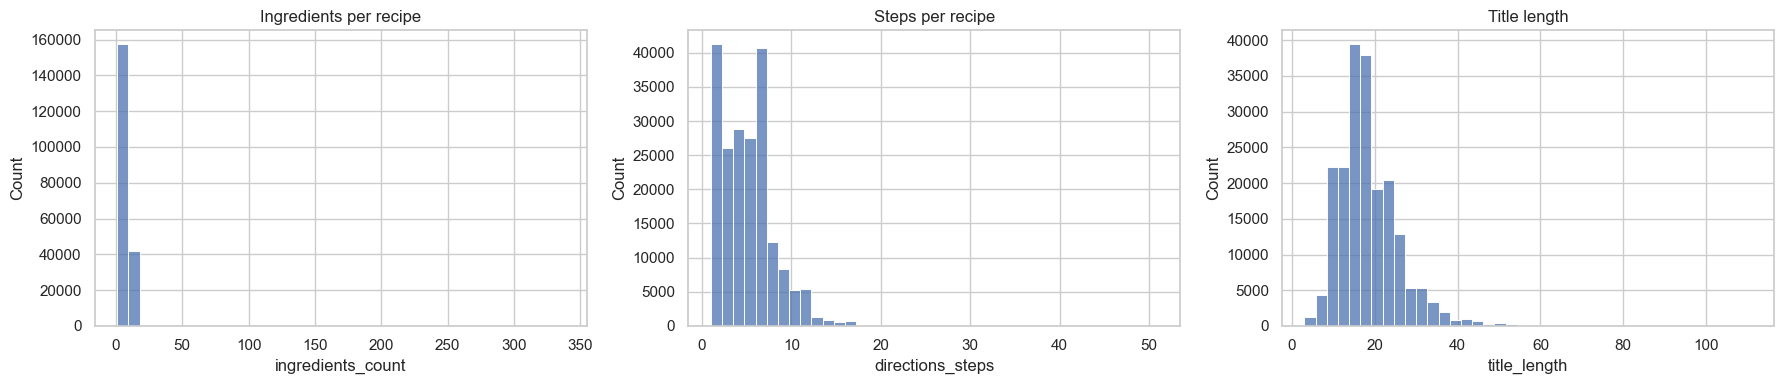

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(length_df['ingredients_count'].dropna(), bins=40, ax=axes[0])
axes[0].set_title('Ingredients per recipe')
sns.histplot(length_df['directions_steps'].dropna(), bins=40, ax=axes[1])
axes[1].set_title('Steps per recipe')
sns.histplot(length_df['title_length'].dropna(), bins=40, ax=axes[2])
axes[2].set_title('Title length')
plt.tight_layout()
plt.show()


## 来源分布（全量分块统计）
- 使用 chunksize 避免 OOM
- barplot 展示来源比例


,count
source,
Gathered,1643098.0
Recipes1M,588044.0


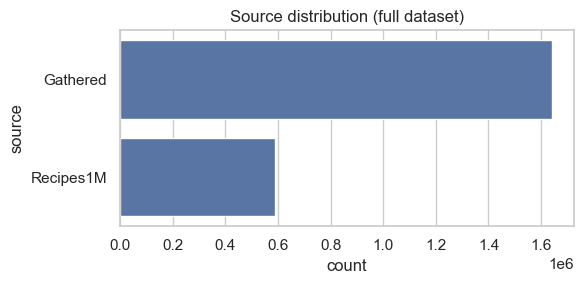

In [7]:
source_counts = pd.Series(dtype='int64')
for chunk in pd.read_csv(data_path, usecols=['source'], chunksize=chunk_size):
    source_counts = source_counts.add(chunk['source'].value_counts(), fill_value=0)
source_counts = source_counts.sort_values(ascending=False)

display(source_counts.to_frame('count'))
plt.figure(figsize=(6, 3))
sns.barplot(x=source_counts.values, y=source_counts.index)
plt.title('Source distribution (full dataset)')
plt.xlabel('count')
plt.tight_layout()
plt.show()


## NER 高频实体（全量分块统计）
- 将 NER 字段解析为列表并累加计数
- 可用于后续构建食材字典或标签体系


,count
salt,1013713
sugar,662836
butter,539979
flour,488089
eggs,422213
onion,391271
garlic,388187
milk,370287
water,351248
vanilla,293882


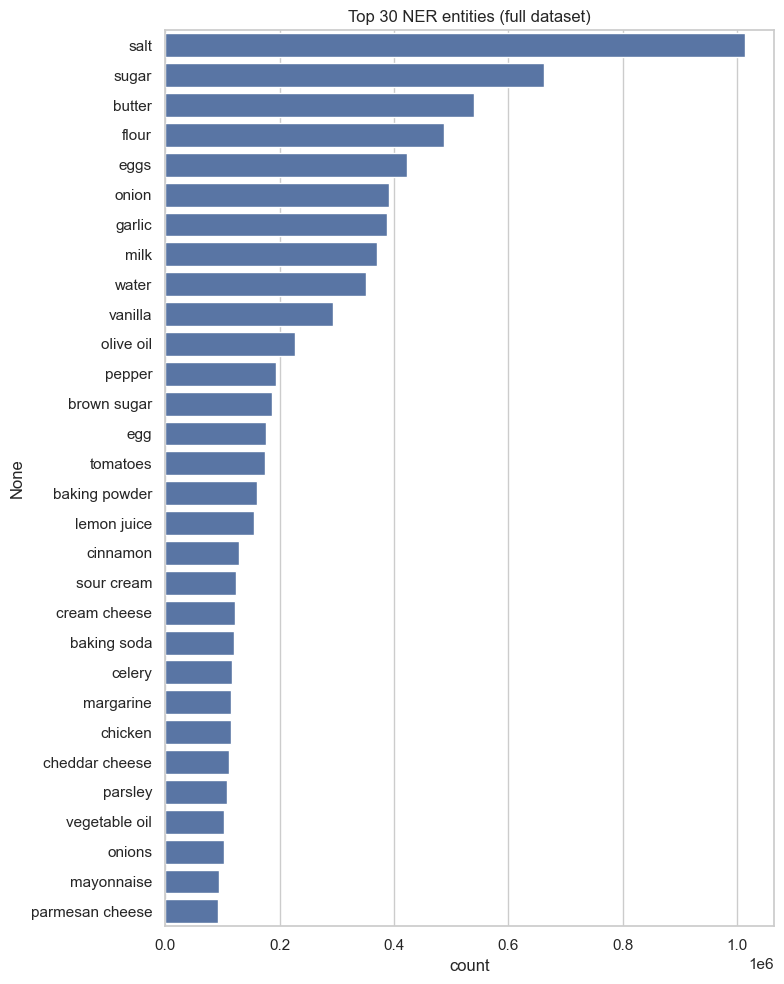

In [8]:
ner_counter = Counter()
for chunk in pd.read_csv(data_path, usecols=['NER'], chunksize=50_000):
    for values in chunk['NER'].dropna():
        try:
            for token in json.loads(values):
                token_clean = token.strip().lower()
                if token_clean:
                    ner_counter[token_clean] += 1
        except Exception:
            continue

ner_series = pd.Series(ner_counter).sort_values(ascending=False)
top_ner = ner_series.head(30)
display(top_ner.to_frame('count'))

plt.figure(figsize=(8, 10))
sns.barplot(x=top_ner.values, y=top_ner.index)
plt.title('Top 30 NER entities (full dataset)')
plt.xlabel('count')
plt.tight_layout()
plt.show()


## 重复情况（样本）
- 标题/链接重复率
- 对后续去重、建模有参考价值


In [9]:
dup_title_rate = df_sample['title'].duplicated().mean()
dup_link_rate = df_sample['link'].duplicated().mean()
print(f'Title duplicate rate (sample): {dup_title_rate:.4f}')
print(f'Link duplicate rate (sample): {dup_link_rate:.4f}')


Title duplicate rate (sample): 0.5507
Link duplicate rate (sample): 0.0000
